# Visualizing neuronal data

## Tuning curves
sigmoidal, bell-shaped

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ncb.mplstyle')
h=0.005
input_onset=150             # Onset of input
input_amp=5                 # AMPLITUDE OF INPUT
total_time=1100             # Total simulation time in ms

time=np.arange(0,total_time,h)  # time period 1000ms (1s)
fs=1000/h

def Input(input_onset,input_amp):
    I=np.zeros((len(time)))     # CURRENT (INPUT)

    for k in range (0,len(time)):
        if time[k] >input_onset:
            I[k]=input_amp # Input change
    return I


# Numerical Solution to the Izhikevich model
def Discrete_Model(a,b,u,v,I):
    v = v + h *(0.04*v*v+5*v+140-u+I) # Discrete form of membrane potential of the neuron
    u = u + h *(a*(b*v-u))            # Discrete form of membrane recovery variable
    return u,v

def Izhikevich(a,b,c,d):
    v=-65*np.ones((len(time)))  # SETS UP THE INITIAL VALUES of the membrane potential
    u=0*np.ones((len(time)))    # SETS UP THE INITIAL VALUES of the membrane recovery
    u[0]=b*v[0]                 # INITIAL CONDITION

    firing_time=[]

    I=Input(input_onset,input_amp)
    # EULER METHOD
    for k in range (0,len(time)-1):
        u[k+1],v[k+1]=Discrete_Model(a,b,u[k],v[k],I[k]) # Numerically solving the equations at each time point

        if v[k+1]>30:
            v[k+1]=c
            u[k+1]=u[k+1]+d
            firing_time.append(time[k])
    # plot_input_output(time,v,I,a,b,c,d,firing_time)
    w=(v-v.min())
    w=w/(1.1*w.max())

    return v, firing_time

## Neuronal tuning curves
stim vs rate

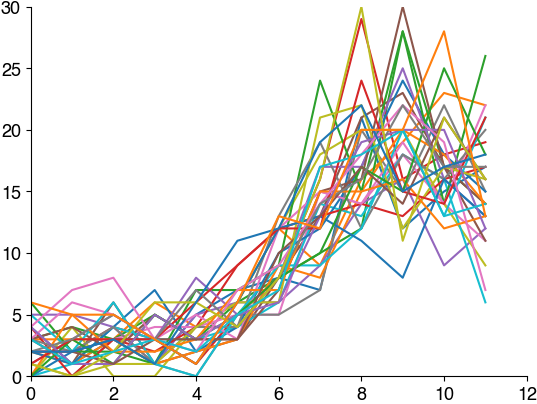

In [2]:
# REMVOVE
import pandas as pd

df = pd.read_excel('dat/data_assignment.xls')
df = df[df['animal']==2]
df['intensity'] = df['probe'] / df['background']
df.drop(columns=['probe', 'background', 'animal'], inplace=True)
df.head()
df = {'intensity': df['intensity'].to_numpy(), 'response': df['response'].to_numpy()}
# np.savez('JON_CAPs.npz', **data)

# make this 2d int x trial
avg = []
trials = []
intensities = np.unique(df['intensity'])

for intensity in intensities:
    this_intensity = df['intensity'] == intensity
    avg.append(np.mean(df['response'][this_intensity]))

    trials.append(np.random.poisson(avg[-1] * 16 + 1, 32))
# plt.plot(avg)
plt.plot(trials)

np.savez('dat/auditory_RN.npz', intensities=intensities, trials=trials)


NpzFile 'dat/auditory_RN.npz' with keys: intensities, trials
(12,) (12, 32)


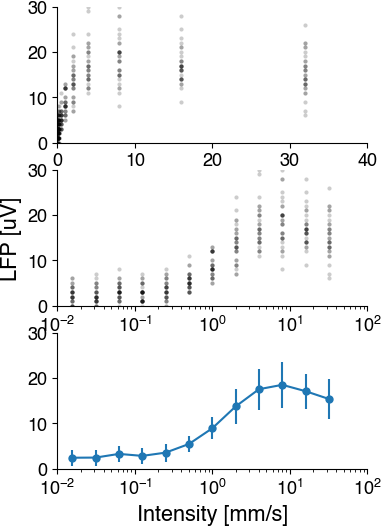

In [3]:
df = np.load('dat/auditory_RN.npz')
print(df)
print(df['intensities'].shape, df['trials'].shape)

plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(df['intensities'], df['trials'], '.k', alpha=0.2)
# plt.xlabel('Intensity [mm/s]')

plt.subplot(312)
plt.plot(df['intensities'], df['trials'], '.k', alpha=0.2)
plt.xscale('log')
# plt.xlabel('Intensity [mm/s]')
plt.ylabel('LFP [uV]')

avg = np.mean(df['trials'], axis=1)
std = np.std(df['trials'], axis=1)

plt.subplot(313)
plt.errorbar(intensities, avg, yerr=std, fmt='o-', label='Data')
plt.xscale('log')
plt.xlabel('Intensity [mm/s]')
plt.show()


## Two neurons with distinct firing rate dynamics

In [4]:
# REMOVE
input_amp=4
v1, r1 = Izhikevich(0.02,0.2,-65,8)
v2, r2 = Izhikevich(0.02,0.2,-52,2)
np.savez('dat/two_neurons.npz', voltage1=v1, voltage2=v2, spike_times1=r1, spike_times2=r2, time=time)


### Membrane voltages

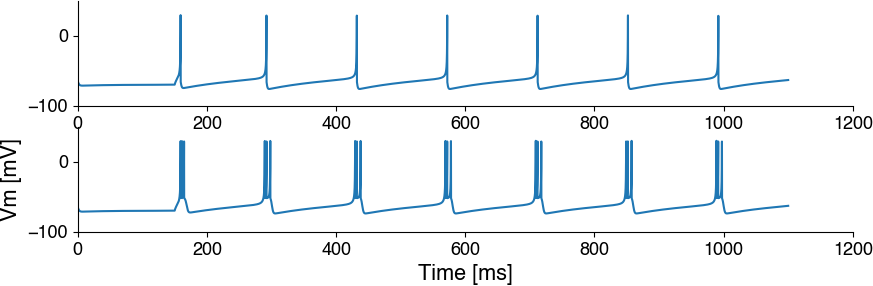

In [5]:
tn = np.load('dat/two_neurons.npz')

plt.figure(figsize=(10, 3))
plt.subplot(211)
plt.plot(tn['time'], tn['voltage1'])

plt.subplot(212)
plt.plot(tn['time'], tn['voltage2'])
plt.xlabel('Time [ms]')
plt.ylabel('Vm [mV]')
plt.show()

### Peri-stimulus time histograms (PSTH)

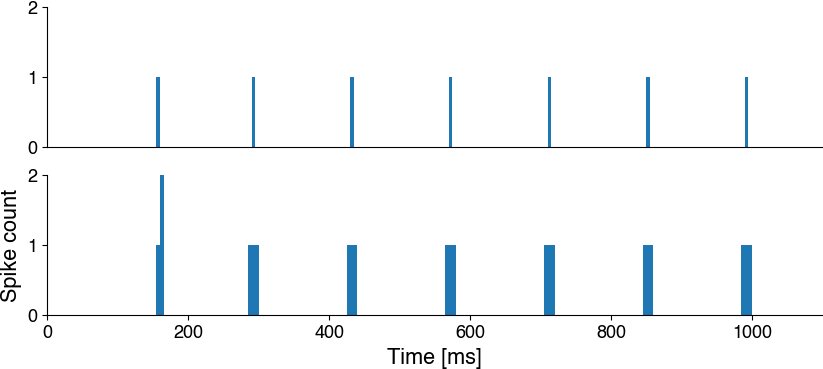

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.hist(tn['spike_times1'], bins=np.arange(0, 1050, 5))
plt.xticks([])
plt.ylim(0, 2)
plt.xlim(0, 1100)

plt.subplot(212)
plt.hist(tn['spike_times2'], bins=np.arange(0, 1050, 5))
plt.xlim(0, 1100)
plt.xlabel('Time [ms]')
plt.ylabel('Spike count')
plt.show()

### Inter-spike intervals

Text(0.5, 0, 'Inter-spike interval [ms]')

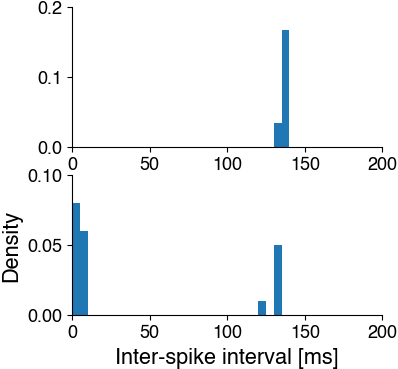

In [7]:
ISI1 = tn['spike_times1'][1:] - tn['spike_times1'][:-1]
ISI2 = np.diff(tn['spike_times2'])

plt.figure(figsize=(4,4))
plt.subplot(211)
plt.hist(ISI1, bins=np.arange(0, 200, 5), density=True)
plt.subplot(212)
plt.hist(ISI2, bins=np.arange(0, 200, 5), density=True)
plt.ylabel('Density')
plt.xlabel('Inter-spike interval [ms]')

## Grid and place cells

In [8]:
# REMOVE
d = np.load('dat/positions.npz')
mouse_tracks = d['female_positions'] / 3 * 7
mouse_times = d['time'] / 10

center = [20, 20]
dist_to_center = np.sqrt((mouse_tracks[:, 0] - center[0])**2 + (mouse_tracks[:, 1] - center[1])**2)
potential_spike_times = mouse_times[dist_to_center<10]
np.random.seed(1)
spike_times1 = np.random.choice(potential_spike_times, 32, replace=False)

center = [45, 35]
dist_to_center = np.sqrt((mouse_tracks[:, 0] - center[0])**2 + (mouse_tracks[:, 1] - center[1])**2)
potential_spike_times = mouse_times[dist_to_center<20]
np.random.seed(1)
spike_times2 = np.random.choice(potential_spike_times, 24, replace=False)

np.savez('dat/mouse_tracks.npz', tracks=mouse_tracks, times=mouse_times, spike_times2=spike_times2, spike_times1=spike_times1)


(np.float64(0.0), np.float64(70.0), np.float64(0.0), np.float64(70.0))

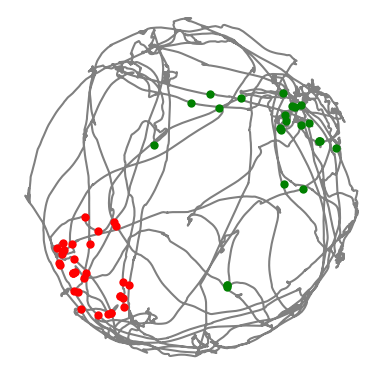

In [9]:
d = np.load('dat/mouse_tracks.npz')

plt.plot(d['tracks'][:, 0], d['tracks'][:, 1], 'Grey')

indices = []
for spike_time in d['spike_times1']:
    # find index of spike time in d['times']
    index = np.where(d['times'] == spike_time)[0][0]
    indices.append(index)

plt.plot(d['tracks'][indices, 0], d['tracks'][indices, 1], 'ro')


indices = []
for spike_time in d['spike_times2']:
    # find index of spike time in d['times']
    index = np.where(d['times'] == spike_time)[0][0]
    indices.append(index)

plt.plot(d['tracks'][indices, 0], d['tracks'][indices, 1], 'go')
plt.axis('square')
plt.axis('off')